<a href="https://colab.research.google.com/github/fernandojunior/deteccao-fraude/blob/master/src/Fraud_Detection_Xente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark load lib

In [7]:
'''!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install pandas_ml
!pip install -q findspark
!pip install catboost
!pip install -U imbalanced-learn
!pip install pyod seaborn catboost plotly_express==0.4.0
!pip install --upgrade pyod
!pip install shap
!pip install --user --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
#!pip install -r requirements.txt'''

import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('xente').getOrCreate()
spark

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark.sql.functions as F
import shap
import catboost
from catboost import Pool, CatBoostClassifier, cv

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean, udf, array, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                              f1_score, precision_score, recall_score, roc_auc_score)

# Load Training Data

In [8]:
def read_data_from_web(url):
  data = pd.read_csv(url)
  spark_data = spark.createDataFrame(data)
  return spark_data

fraud_data = read_data_from_web("https://drive.google.com/uc?export=download&id=1NrtVkKv8n_g27w5elq9HWZA1i8aFBW0G")
df_backup = fraud_data

In [21]:
fraud_data.show(5)

+-------------------+------------+------------+------------------+-----------+-------+-----+---------------+-----------+
|      TransactionId|  ProviderId|   ProductId|   ProductCategory|  ChannelId| Amount|Value|PricingStrategy|FraudResult|
+-------------------+------------+------------+------------------+-----------+-------+-----+---------------+-----------+
|TransactionId_76871|ProviderId_6|ProductId_10|           airtime|ChannelId_3| 1000.0| 1000|              2|          0|
|TransactionId_73770|ProviderId_4| ProductId_6|financial_services|ChannelId_2|  -20.0|   20|              2|          0|
|TransactionId_26203|ProviderId_6| ProductId_1|           airtime|ChannelId_3|  500.0|  500|              2|          0|
|  TransactionId_380|ProviderId_1|ProductId_21|      utility_bill|ChannelId_3|20000.0|21800|              2|          0|
|TransactionId_28195|ProviderId_4| ProductId_6|financial_services|ChannelId_2| -644.0|  644|              2|          0|
+-------------------+-----------

## Data Dictionary

*   **TransactionId:** Unique transaction identifier on platform.
*   **BatchId:** Unique number assigned to a batch of transactions for processing.
*   **AccountId:** Unique number identifying the customer on platform.
*   **SubscriptionId:** Unique number identifying the customer subscription.
*   **CustomerId:** Unique identifier attached to Account.
*   **CurrencyCode:** Country currency.
*   **CountryCode:** Numerical geographical code of country.
*   **ProviderId:** Source provider of Item bought.
*   **ProductId:** Item name being bought.
*   **ProductCategory:** ProductIds are organized into these broader product categories.
*   **ChannelId:** Identifies if customer used web,Android, IOS, pay later or checkout.
*   **Amount:** Value of the transaction. Positive for debits from customer account and negative for credit into customer account.
*   **Value:** Absolute value of the amount.
*   **TransactionStartTime:** Transaction start time.
*   **PricingStrategy:** Category of Xente's pricing structure for merchants.
*   **FraudResult:** Fraud status of transaction: 1) Yes; or 0) No.

In [9]:
fraud_data.printSchema()

root
 |-- TransactionId: string (nullable = true)
 |-- BatchId: string (nullable = true)
 |-- AccountId: string (nullable = true)
 |-- SubscriptionId: string (nullable = true)
 |-- CustomerId: string (nullable = true)
 |-- CurrencyCode: string (nullable = true)
 |-- CountryCode: long (nullable = true)
 |-- ProviderId: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- ProductCategory: string (nullable = true)
 |-- ChannelId: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Value: long (nullable = true)
 |-- TransactionStartTime: string (nullable = true)
 |-- PricingStrategy: long (nullable = true)
 |-- FraudResult: long (nullable = true)



# Data Preprocessing

## Missing Data Analysis

In [10]:
def there_is_missing_data(data):
  return data.count() != data.na.drop(how='any').count()

print('There is missing data? {0}.'.format(there_is_missing_data(fraud_data)))

There is missing data? False.


## Duplicated line?

In [12]:
def there_is_duplicate_lines(data):
  return data.count() != data.distinct().count()

print('There is distinct data? {0}.'.format(there_is_duplicate_lines(fraud_data)))

There is distinct data? False.


## Data Treatment

In [13]:
fraud_data.withColumn('diff', F.abs(fraud_data['Amount'])-F.col('Value')).select('diff').show()

+-------+
|   diff|
+-------+
|    0.0|
|    0.0|
|    0.0|
|-1800.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
|    0.0|
+-------+
only showing top 20 rows



It shows the real transaction value. To be precise, we need to categorize the transaction, but first, let us remove unuseful features.

## Removing unuseful features

In [28]:
print('Different CurrencyCode Values: \t\t {0}'.format(fraud_data.select('CurrencyCode').distinct().count()))
print('Different de CountryCode Values: \t {0}'.format(fraud_data.select('CountryCode').distinct().count()))
print('Different de TransactionId Values: \t {0}'.format(fraud_data.select('TransactionId').distinct().count()))

Different CurrencyCode Values: 		 1
Different de CountryCode Values: 	 1
Different de TransactionId Values: 	 95662


CurrencyCode and CountryCode columns have the same value in whole dataset, genuine or fraud.

In [14]:
# data: dataframe - columns: column list to remove
def remove_feature(data, columns_in):
  return data.drop(*columns_in)

In [16]:
def clean_data(fraud_data, columns_to_remove):
  fraud_data = remove_feature(fraud_data, columns_to_remove)
  return fraud_data

In [17]:
columns_to_remove = ['CurrencyCode','CountryCode','BatchId','AccountId','SubscriptionId','CustomerId', 'TransactionStartTime']
fraud_data = clean_data(fraud_data, columns_to_remove)

In [24]:
fraud_data.show(5)

+-------------------+------------+------------+------------------+-----------+-------+-----+---------------+-----------+
|      TransactionId|  ProviderId|   ProductId|   ProductCategory|  ChannelId| Amount|Value|PricingStrategy|FraudResult|
+-------------------+------------+------------+------------------+-----------+-------+-----+---------------+-----------+
|TransactionId_76871|ProviderId_6|ProductId_10|           airtime|ChannelId_3| 1000.0| 1000|              2|          0|
|TransactionId_73770|ProviderId_4| ProductId_6|financial_services|ChannelId_2|  -20.0|   20|              2|          0|
|TransactionId_26203|ProviderId_6| ProductId_1|           airtime|ChannelId_3|  500.0|  500|              2|          0|
|  TransactionId_380|ProviderId_1|ProductId_21|      utility_bill|ChannelId_3|20000.0|21800|              2|          0|
|TransactionId_28195|ProviderId_4| ProductId_6|financial_services|ChannelId_2| -644.0|  644|              2|          0|
+-------------------+-----------

## Categorizing columns values

In [30]:
fraud_data = fraud_data.withColumn('ProviderId_int', F.split(fraud_data['ProviderId'], '_').getItem(1).cast(IntegerType()) )
fraud_data = fraud_data.withColumn('ProductId_int', F.split(fraud_data['ProductId'], '_').getItem(1).cast(IntegerType()) )
fraud_data = fraud_data.withColumn('ChannelId_int', F.split(fraud_data['ChannelId'], '_').getItem(1).cast(IntegerType()) )

# Creating Features

## Removing dependeces

In [32]:
def get_features_augmentation(fraud_data, clean=False):
  fraud_data = fraud_data.withColumn("Operation", F.when(fraud_data.Amount > 0, 1).when(fraud_data.Amount < 0, -1).otherwise(0))
  fraud_data = fraud_data.withColumn('PositiveAmount', F.abs(fraud_data['Amount']))
  
  gen_train_data = fraud_data.filter('FraudResult == 0')
  items_list = ['ChannelId', 'ProductCategory', 'ProductId']

  for item in items_list:
    mean_column_name = 'avg_ps_{0}'.format(item)
    ratio_column_name = 'rt_avg_ps_{0}'.format(item)
    aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
    aux = aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
    fraud_data = fraud_data.join(aux, on=item)
    fraud_data = fraud_data.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))
  
  if clean:
    fraud_data = clean_data(fraud_data)
  
  return fraud_data

In [33]:
fraud_data = get_features_augmentation(fraud_data)
fraud_data = clean_data(fraud_data, columns_to_remove = ['Amount'])

In [35]:
fraud_data.printSchema()

root
 |-- ProductId: string (nullable = true)
 |-- ProductCategory: string (nullable = true)
 |-- ChannelId: string (nullable = true)
 |-- TransactionId: string (nullable = true)
 |-- BatchId: string (nullable = true)
 |-- AccountId: string (nullable = true)
 |-- SubscriptionId: string (nullable = true)
 |-- CustomerId: string (nullable = true)
 |-- CurrencyCode: string (nullable = true)
 |-- CountryCode: long (nullable = true)
 |-- ProviderId: string (nullable = true)
 |-- Value: long (nullable = true)
 |-- TransactionStartTime: string (nullable = true)
 |-- PricingStrategy: long (nullable = true)
 |-- FraudResult: long (nullable = true)
 |-- ProviderId_cat: integer (nullable = true)
 |-- ProductId_cat: integer (nullable = true)
 |-- ChannelId_cat: integer (nullable = true)
 |-- Operation: integer (nullable = false)
 |-- PositiveAmount: double (nullable = true)
 |-- avg_ps_ChannelId: double (nullable = true)
 |-- rt_avg_ps_ChannelId: double (nullable = true)
 |-- avg_ps_ProductCategor

# Data Analysis

ProductCategory have a bias to fraud transaction

In [37]:
fraud_data.filter('FraudResult == 0').groupBy('ProductCategory' ).count().show()

+------------------+-----+
|   ProductCategory|count|
+------------------+-----+
|            ticket|  216|
|                tv| 1279|
|             other|    2|
|           airtime|45009|
|         transport|   23|
|      data_bundles| 1613|
|            movies|  175|
|      utility_bill| 1908|
|financial_services|45244|
+------------------+-----+



In [38]:
fraud_data.filter('FraudResult == 1').groupBy('ProductCategory' ).count().show()

+------------------+-----+
|   ProductCategory|count|
+------------------+-----+
|         transport|    2|
|           airtime|   18|
|      utility_bill|   12|
|financial_services|  161|
+------------------+-----+



Counting the number of transactions by category, let us normalize and show in histogram graphic.

Percebe-se que as transações fraudulentas (representadas em azul), incidem principalmente em operações do tipo Serviço financeiro, como também Airtime e Utility_bill.

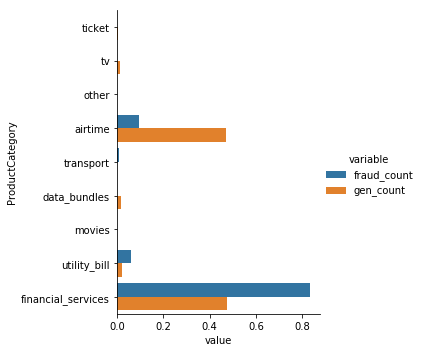

In [36]:
df1 = fraud_data.filter('FraudResult == 0').groupBy('ProductCategory' ).count()
df1 = df1.withColumnRenamed('count', 'gen_count')

df2 = fraud_data.filter('FraudResult == 1').groupBy('ProductCategory' ).count()
df2 = df2.withColumnRenamed('count', 'fraud_count')

new_df = df1.join(df2, on=['ProductCategory'], how='left_outer')
new_df = new_df.fillna({'fraud_count': '0'})

new_df_pd = new_df.toPandas()
new_df_pd['gen_count'] = new_df_pd['gen_count']/sum(new_df_pd['gen_count'])
new_df_pd['fraud_count'] = new_df_pd['fraud_count']/sum(new_df_pd['fraud_count'])
new_df_pd = pd.melt(new_df_pd, id_vars='ProductCategory', value_vars=['fraud_count', 'gen_count'], value_name='value')

sns.catplot(y='ProductCategory', hue='variable', x='value', kind='bar', data=new_df_pd);

Categorizing ProductCategory

In [40]:
indexer = StringIndexer(inputCol = 'ProductCategory', outputCol='ProductCategory_int')
fraud_data = indexer.fit(fraud_data).transform(fraud_data)

# Statistics

## Imbalanced dataset

In [42]:
fraud_data.groupBy("FraudResult").count().show()
outlier_fraction = fraud_data.filter("FraudResult == 1").count() / fraud_data.filter("FraudResult == 0").count()
print('Os dados fraudulentos representam {0:.3f}% dos dados.'.format(outlier_fraction*100))

+-----------+-----+
|FraudResult|count|
+-----------+-----+
|          0|95469|
|          1|  193|
+-----------+-----+

Os dados fraudulentos representam 0.202% dos dados.


## Descriptive analysis of numerical variables

In [43]:
#feature_cols = ['PositiveAmount','Operation','Value','PricingStrategy','ProviderId_int','ProductId_int','ChannelId_int','ProductCategory_int']
feature_cols = ['PositiveAmount','Operation','Value','PricingStrategy']

In [45]:
print('Fraud data set')
fraud_data.select(feature_cols).filter(fraud_data['FraudResult'] == 1).toPandas().describe()

Fraud data set


,PositiveAmount,Operation,Value,PricingStrategy
count,1.930000e+02,193.000000,1.930000e+02,193.000000
mean,1.560153e+06,0.948187,1.561820e+06,1.704663
std,2.082015e+06,0.318540,2.081227e+06,0.963300
min,5.000000e+02,-1.000000,5.000000e+02,0.000000
25%,5.000000e+05,1.000000,5.000000e+05,2.000000
50%,6.500000e+05,1.000000,6.500000e+05,2.000000
75%,2.000000e+06,1.000000,2.000000e+06,2.000000
max,9.880000e+06,1.000000,9.880000e+06,4.000000


In [46]:
print('Genuine data set')
fraud_data.select(feature_cols).filter(fraud_data['FraudResult'] == 0).toPandas().describe()

Genuine data set


,PositiveAmount,Operation,Value,PricingStrategy
count,9.546900e+04,95469.000000,9.546900e+04,95469.000000
mean,6.723033e+03,0.200075,6.763227e+03,2.257089
std,3.995819e+04,0.979786,3.999484e+04,0.731971
min,1.200000e+00,-1.000000,2.000000e+00,0.000000
25%,2.500000e+02,-1.000000,2.500000e+02,2.000000
50%,1.000000e+03,1.000000,1.000000e+03,2.000000
75%,5.000000e+03,1.000000,5.000000e+03,2.000000
max,2.400000e+06,1.000000,2.400000e+06,4.000000


In [48]:
mean_value = fraud_data.select(mean(fraud_data['value'])).collect()[0][0]

print('Mean Value of transactions US$ {0:.2f}'.format(mean_value))

Mean Value of transactions US$ 9900.58


In [51]:
percentFraudByAvgValueLow = fraud_data.filter("FraudResult == 1 and PositiveAmount < " + str(mean_value) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGenByAvgValueLow = fraud_data.filter("FraudResult == 0 and PositiveAmount < "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 0').count()

percentFraudByAvgValueHigh = fraud_data.filter("FraudResult == 1 and PositiveAmount > "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGenByAvgValueHigh = fraud_data.filter("FraudResult == 0 and PositiveAmount > "+ str(mean_value) ).count() / fraud_data.filter('FraudResult == 0').count()


print('Fraud Transactions under average value: \t{0:.2f}%.'.format(percentFraudByAvgValueLow * 100))
print('Fraud Transactions over average value: \t{0:.2f}%.\n'.format(percentFraudByAvgValueHigh * 100))

print('Genuine Transactions under average value: \t{0:.2f}%.'.format(percentGenByAvgValueLow * 100))
print('Genuine Transactions over average value: \t\t{0:.2f}%.'.format(percentGenByAvgValueHigh * 100))

Fraud Transactions under average value: 	1.04%.
Fraud Transactions over average value: 	98.96%.

Genuine Transactions under average value: 	80.61%.
Genuine Transactions over average value: 		19.39%.


In [53]:
mean_val_fraud = fraud_data.filter("FraudResult == 1").select(mean(fraud_data['value'])).collect()[0][0]
mean_val_notfraud = fraud_data.filter("FraudResult == 0").select(mean(fraud_data['value'])).collect()[0][0]

print('Average Value of a fraud transaction: \t\tUS$ {0:.2f}.'.format(mean_val_fraud))
print('Average Value of a genuine transaction: \tUS$ {0:.2f}.'.format(mean_val_notfraud))

Average Value of a fraud transaction: 		US$ 1561819.54.
Average Value of a genuine transaction: 	US$ 6763.23.


In [54]:
percentFraud2ByAvgValue = fraud_data.filter("FraudResult == 1 and PositiveAmount > "+ str(mean_val_fraud) ).count() / fraud_data.filter('FraudResult == 1').count()
percentGen2ByAvgValue = fraud_data.filter("FraudResult == 0 and PositiveAmount > "+ str(mean_val_notfraud) ).count() / fraud_data.filter('FraudResult == 0').count()

print('Mount of fraud transaction over the average: \t\t{0:.1f}%'.format(percentFraud2ByAvgValue * 100))
print('Mount of genuine transaction over the average: \t{0:.1f}%'.format(percentGen2ByAvgValue * 100))

Mount of fraud transaction over the average: 		27.5%
Mount of genuine transaction over the average: 	20.4%


In [56]:
percentFraudByOperation = fraud_data.filter("FraudResult == 1 and Operation == 1 ").count() / fraud_data.filter('FraudResult == 1').count()
percentGenByOperation = fraud_data.filter("FraudResult == 0 and Operation == 1 ").count() / fraud_data.filter('FraudResult == 0').count()

print('Debit Fraud Transaction:  {0:.1f}%.'.format(percentFraudByOperation * 100))
print('Credit Fraud Transaction: {0:.1f}%.\n'.format(100-(percentFraudByOperation * 100)))

print('Debit Genuine Transaction:  {0:.1f}%.'.format(percentGenByOperation * 100))
print('Credit Genuine Transaction: {0:.1f}%.'.format(100-(percentGenByOperation * 100)))

Debit Fraud Transaction:  97.4%.
Credit Fraud Transaction: 2.6%.

Debit Genuine Transaction:  60.0%.
Credit Genuine Transaction: 40.0%.
